In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import os

In [4]:
def red_blue_intervals(ts,intervals):
    blue = []
    red = []
    blue.append(ts.iloc[0:intervals['start'][0]])
    #print(len(blue))
    for i in range(len(intervals)-1):
        blue.append(ts.iloc[intervals['stop'][i]:intervals['start'][i+1]])
    blue.append(ts.iloc[intervals['stop'][len(intervals)-1]:len(ts)])
    
    for i in range(len(intervals)):
        red.append(ts.iloc[intervals['start'][i]:intervals['stop'][i]])
    blue = pd.concat(blue, ignore_index=False)
    red = pd.concat(red, ignore_index=False)
    return red, blue

Test the time needed to flip a boolean for the dataframe:
52.9s

In [3]:
df = pd.read_csv("spot-the-trend-train-data/example1.csv" ,sep="\t")
df['label'] = False
for i in range(len(df)):
    df.loc[i,"label"] = True
    #print(df)

In [65]:
def integrate_intervals(ts, intervals):
    ts['red'] = False
    for i in range(len(intervals)):
        #ts['red'].iloc[intervals['start'][i]:intervals['stop'][i]] = True
        ts.loc[intervals['start'][i]:intervals['stop'][i],'red'] = True
    return ts
def read_data(path:str, count: int):
    dir_list = os.listdir(path)
    train_dir = []
    for file in dir_list:
        if not file.__contains__('intervals'):
            train_dir.append(file)
    
    data = []
    counter = 0
    for file in train_dir:
        interval = file.replace('.csv','_intervals.csv')
        try:
            intervals = pd.read_csv(path + "/" + interval)
            ts = pd.read_csv(path + "/" + file ,sep="\t")
            data.append(integrate_intervals(ts,intervals))
            print(file)
        except: 
            print(file)    
        counter += 1
        if counter >= count:
            break
    return data
def df_to_intervals(df):
    red = False
    intervals = []
    print(len(intervals))
    for i in range(len(df)):
        if red == False:
            if df.loc[i,'red'] == True:
                intervals.append(i)
                red = True
        if red == True:
            if df.loc[i,'red'] == False:
                intervals.append(i-1)
                red = False
    return intervals

In [66]:
path = "spot-the-trend-train-data"
data = []
data = read_data(path,1)
print(df_to_intervals(data[0]))

uopfk.csv
0
[46074, 86049, 133846, 173972, 196853, 197037, 328533, 375389, 428892, 468631, 490428, 490630, 617999, 664168, 686219, 686400, 788891, 789071, 828585, 875761, 946037, 946253, 1138831, 1179527, 1307443, 1351842, 1466871, 1501412]
28
[46074, 86049, 133846, 173972, 196853, 197037, 328533, 375389, 428892, 468631, 490428, 490630, 617999, 664168, 686219, 686400, 788891, 789071, 828585, 875761, 946037, 946253, 1138831, 1179527, 1307443, 1351842, 1466871, 1501412]


In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from sklearn.impute import SimpleImputer
# Example time series data (replace with your actual data)
#time_series_data = np.array(df['y'], dtype=float)  # Ensure data is float type
window_size = 20



path = "spot-the-trend-train-data"
data_count = 5
data = read_data(path,data_count)
train = np.array(data[0].)

#train = np.array(pd.read_csv("spot-the-trend-train-data/axavx.csv" ,sep="\t")['y'],dtype=float)
#train = np.append(train,np.array(pd.read_csv("spot-the-trend-train-data/cswlh.csv" ,sep="\t")['y'],dtype=float))
#train = np.append(train,np.array(pd.read_csv("spot-the-trend-train-data/dsoir.csv" ,sep="\t")['y'],dtype=float))
#train = np.append(train,np.array(pd.read_csv("spot-the-trend-train-data/eppxh.csv" ,sep="\t")['y'],dtype=float))
#train = np.append(train,np.array(pd.read_csv("spot-the-trend-train-data/evctf.csv" ,sep="\t")['y'],dtype=float))
#train = np.append(train,np.array(pd.read_csv("spot-the-trend-train-data/zrhip.csv" ,sep="\t")['y'],dtype=float))
#train = np.array(train)
train = train.flatten()
print(train.shape)

imputer = SimpleImputer(strategy='mean')
train = imputer.fit_transform(train.reshape(-1, 1)).flatten()

# Create input-output pairs
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sliding_window(train, window_size)


print(np.isnan(X).any())  # Should be False
print(np.isnan(y).any())  # Should be False

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#print()
#print(r2_score(X_train,y_train))
#print(r2_score(X_test,y_test))
#print()

print(np.isnan(X_train).any())  # Should be False
print(np.isnan(y_train).any())  # Should be False
print(np.isinf(X_train).any())  # Should be False
print(np.isinf(y_train).any())  # Should be False

# Ensure the data is of type float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Define the model
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(window_size,)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


bano avar
gooz
[6957.02070562 6957.03917015 6957.05763469 ... 2875.14454154 2875.14387476
 2875.14320798]
(9460802,)
False
False
False
False
False
False
Epoch 1/4
236520/236520 [==============================] - 130s 547us/step - loss: 57393.8945 - val_loss: 61323.1641
Epoch 2/4
236520/236520 [==============================] - 129s 547us/step - loss: 56509.9336 - val_loss: 57884.7773
Epoch 3/4
236520/236520 [==============================] - 131s 553us/step - loss: 56508.9102 - val_loss: 55518.2812
Epoch 4/4
236520/236520 [==============================] - 130s 550us/step - loss: 56519.6875 - val_loss: 57254.6367
Test Loss: 57254.63671875
59130/59130 [==============================] - 20s 334us/step


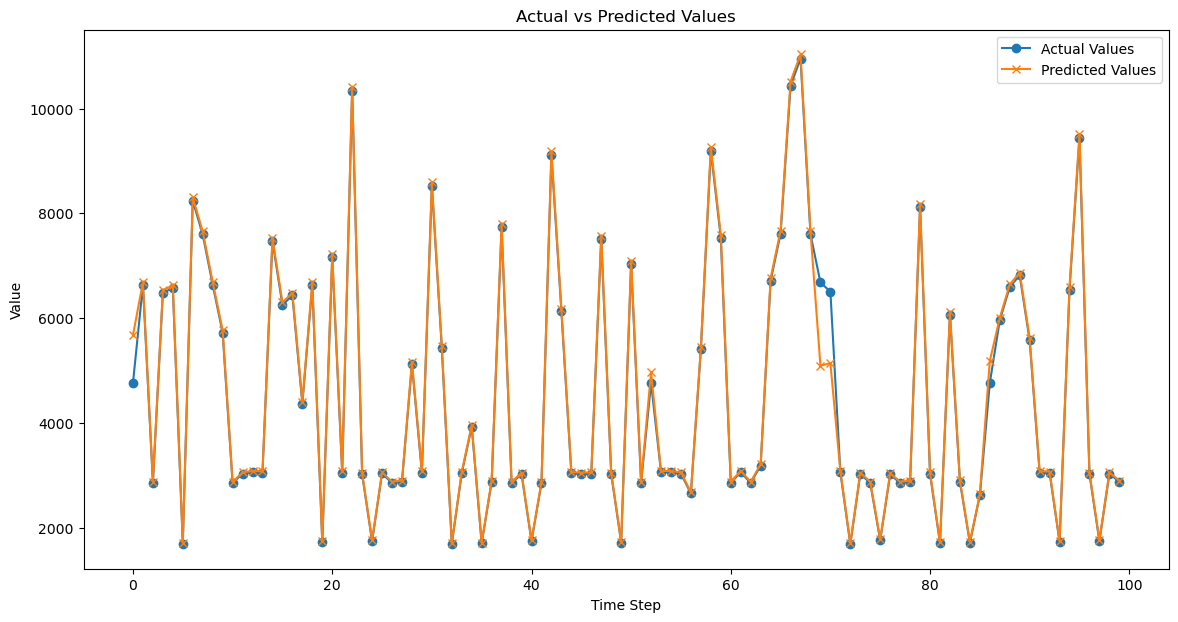

In [20]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

plt.figure(figsize=(14, 7))
plt.plot(y_test[1000:1100], label='Actual Values', marker='o')
plt.plot(predictions[1000:1100], label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()